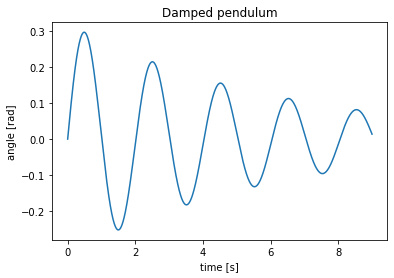

In [29]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

gamma = 3
damping = 0
K = 12
omega = 4
g = 9.81

def pendulum(u, t):
    #Should return y', y''
    # angle'' = -g/l * sin(angle) - damping * radius / mass * angle'
    
    return (u[1], -9.81 * np.sin(u[0]) - 4 * 0.8 / 10 * u[1])

t = np.linspace(0, 9, 10000)
solution = odeint(pendulum, [0, 1], t)
angle = solution[:,0]

plt.plot(t, angle)
plt.title('Damped pendulum')
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')

indices = list(range(len(t)))
cutoff = int(len(solution) * 0.95)

training_indices = indices[0:cutoff]
validation_indices = indices[cutoff:]

training_input = t[sorted(training_indices)]
training_output = angle[sorted(training_indices)]

validation_input = t[sorted(validation_indices)]
validation_output = angle[sorted(validation_indices)]

harvesting states...
fitting...
training error:
1.4850019611949987e-05
R^2 evaluation 0.9738057958580563


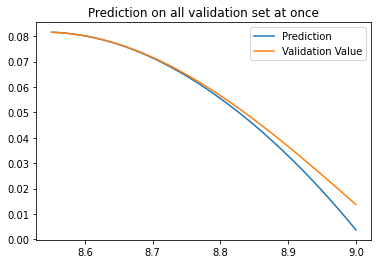

In [36]:
def getESN(n_reservoir, spectral_radius, sparsity, noise, teacher_forcing):
    return ESN(
        1, 
        1, 
        n_reservoir=n_reservoir, # 100
        spectral_radius=spectral_radius, # 0.8
        sparsity=sparsity, # 0.3
        noise=noise, 
        input_shift=None,
        input_scaling=None, 
        teacher_forcing=False, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=None,
        out_activation=lambda x: x, #tanh, sigmoid
        inverse_out_activation=lambda x: x, #TODO ?
        random_state=None, 
        silent=False
    )

esn = getESN(900, 1, 0.1, 0, True)

esn.fit(training_input, training_output)

prediction = esn.predict(validation_input)[:,0]

plt.plot(validation_input, prediction, validation_input, validation_output)
plt.legend(['Prediction', 'Validation Value'])
plt.title('Prediction on all validation set at once')

def compute_R(predicted_angle, known_angle):
    SS_res = ((predicted_angle - known_angle) ** 2).sum()
    avg = known_angle.mean()
    SS_tot = ((known_angle - avg) ** 2).sum() + 0.0000001
     
    if (SS_tot == 0):
        print('Not good')
        
    return 1 - SS_res / SS_tot

print('R^2 evaluation', compute_R(prediction, validation_output))

0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599

Text(0, 0.5, 'Error')

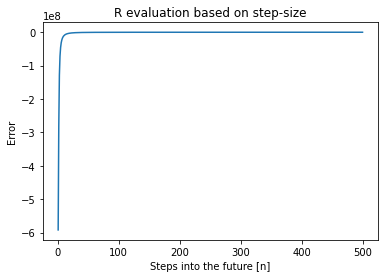

In [23]:
steps = []
R_evaluation = []

temp_prediction = None

#Work in progress
for index in range(1, len(validation_input) + 1):
    steps.append(index)
    
    print(index / len(validation_input) * 100)
    
    temp_prediction = esn.predict(validation_input[0:index])[:,0]
    
    err = compute_R(temp_prediction, validation_input[0:index])
    R_evaluation.append(err)


plt.plot(steps, R_evaluation)
plt.title('R evaluation based on step-size')
plt.xlabel('Steps into the future [n]')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

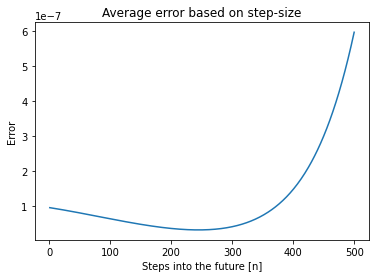

In [24]:
steps = []
average_error = []

temp_prediction = None

for index in range(1, len(validation_input) + 1):
    steps.append(index)
    
    temp_prediction = esn.predict(validation_input[0:index])[:,0]
    
    err = ((temp_prediction - validation_output[0:index]) ** 2).mean()    
    average_error.append(err)


plt.plot(steps, average_error)
plt.title('Average error based on step-size')
plt.xlabel('Steps into the future [n]')
plt.ylabel('Error')